In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
from sklearn.decomposition import PCA

import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import davies_bouldin_score, silhouette_score

In [5]:
customers = pd.read_csv('/content/Customers.csv')
products = pd.read_csv('/content/Products.csv')
transactions = pd.read_csv('/content/Transactions.csv')

data = pd.merge(transactions, customers, on='CustomerID', how='inner')

data = pd.merge(data, products, on='ProductID', how='inner')

In [6]:
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data['SignupDate'] = pd.to_datetime(data['SignupDate'])

data['Price'] = pd.to_numeric(data['Price_y'], errors='coerce')
data['TotalValue'] = pd.to_numeric(data['TotalValue'], errors='coerce')

data.dropna(inplace=True)

In [8]:
reference_date = data['TransactionDate'].max() + pd.Timedelta(days=1)

rfm = data.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (reference_date - x.max()).days,  # Recency
    'TransactionID': 'nunique',                                   # Frequency
    'TotalValue': 'sum'                                           # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [9]:
rfm_log = np.log1p(rfm[['Recency', 'Frequency', 'Monetary']])

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

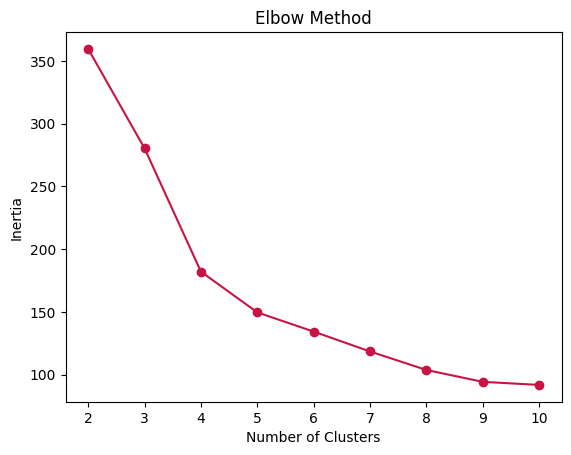

In [20]:
inertia = []
for k in range(2, 11):
    kmeans = ClusterModel(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker='o', color='#c71445')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

[0.37128287432373747, 0.2843407725048419, 0.36352840931468394, 0.36887267659739464, 0.2922923212075322, 0.2924993400512899, 0.32141906452133345, 0.3201906751755953, 0.27976616097112916]


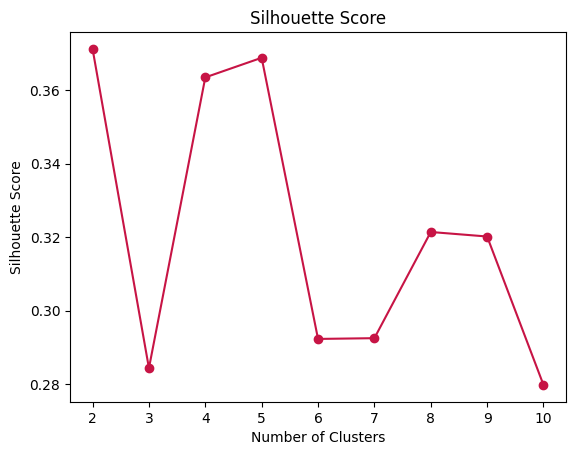

In [19]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(rfm_scaled)
    silhouette_scores.append(silhouette_score(rfm_scaled, cluster_labels))

print(silhouette_scores)

plt.plot(range(2, 11), silhouette_scores, marker='o', color='#c71445')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

Based on the elbow and silhouette methods, we can see that the optimal number of clusters is 6. We can see that the silhouette score is the highest when the number of clusters is 6.

In [22]:
kmeans = ClusterModel(n_clusters=5, random_state=42)
rfm['Cluster_k'] = kmeans.fit_predict(rfm_scaled)

In [24]:
silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
inertia = kmeans.inertia_
db_index = davies_bouldin_score(rfm_scaled, cluster_labels)

print(f"Number of Clusters: 5")
print(f"Silhouette Score: {silhouette_avg}")
print(f"Inertia: {inertia}")
print(f"Davies-Bouldin Index: {db_index}")

Number of Clusters: 5
Silhouette Score: 0.27976616097112916
Inertia: 149.65684057002807
Davies-Bouldin Index: 1.009397277677267


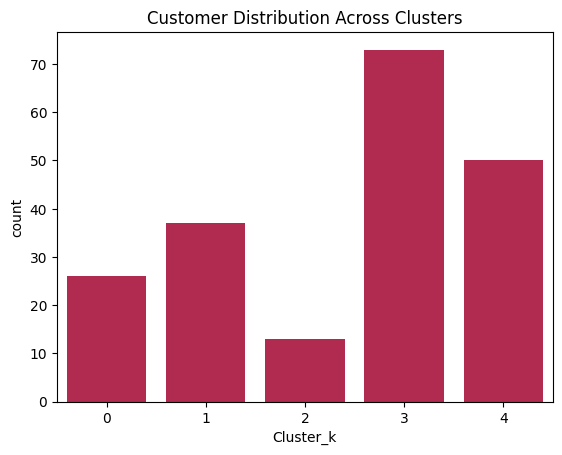

In [26]:
sns.countplot(x='Cluster_k', data=rfm, color='#c71445')
plt.title('Customer Distribution Across Clusters')
plt.show()

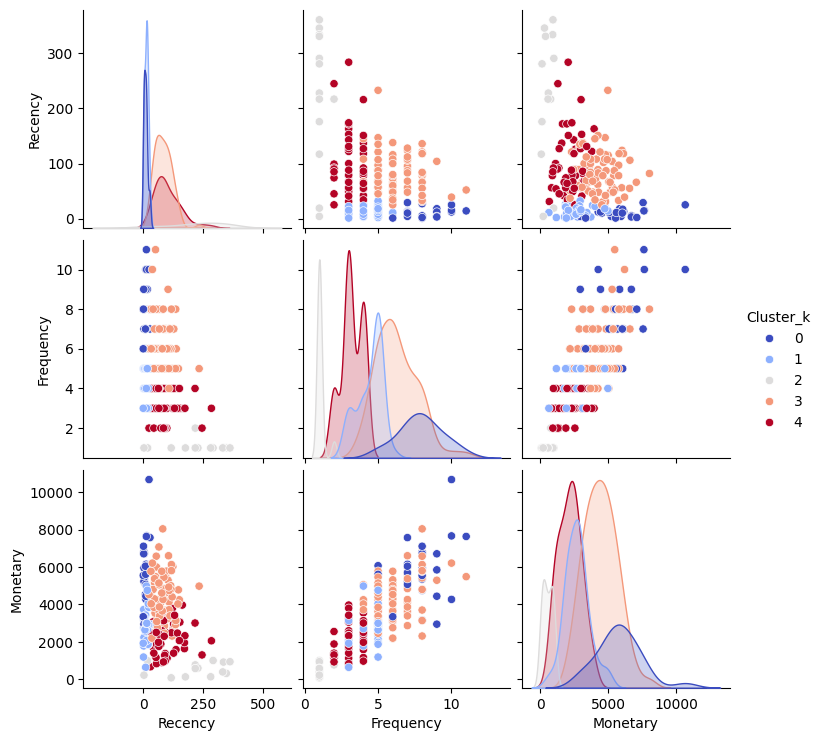

In [30]:
sns.pairplot(rfm, hue='Cluster_k', palette='coolwarm')
plt.show()

In [31]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 4
agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = agglo.fit_predict(rfm_scaled)

rfm['Cluster_ag'] = cluster_labels

In [33]:
silhouette_avg_ag = silhouette_score(rfm_scaled, cluster_labels)
db_index_ag = davies_bouldin_score(rfm_scaled, cluster_labels)

print(f"Number of Clusters: {n_clusters}")
print(f"Silhouette Score: {silhouette_avg_ag}")
print(f"Davies-Bouldin Index: {db_index_ag}")

Number of Clusters: 4
Silhouette Score: 0.2675563048182464
Davies-Bouldin Index: 0.9860550304034842


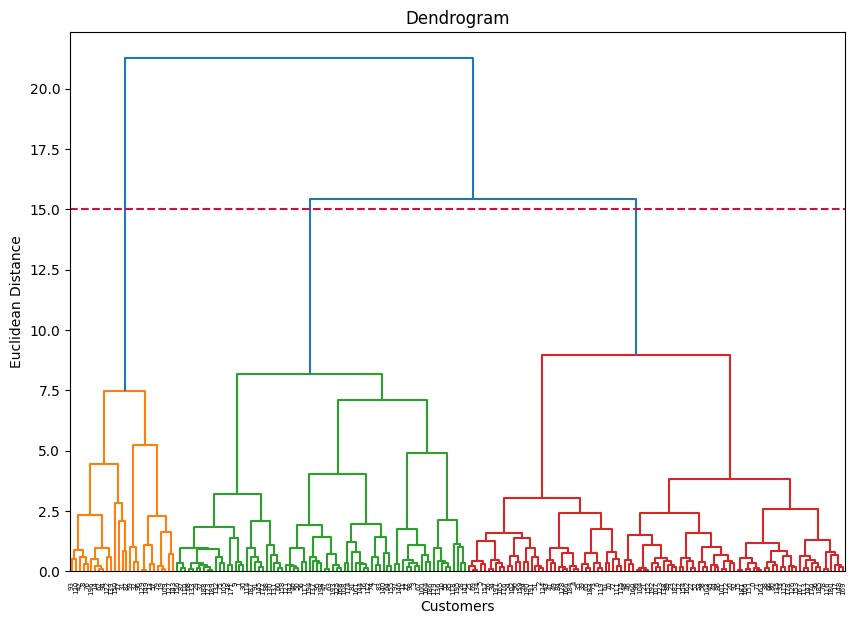

In [35]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
shc.dendrogram(shc.linkage(rfm_scaled, method='ward'))
plt.axhline(y=15, color='#c71445', linestyle='--')
plt.xlabel("Customers")
plt.ylabel("Euclidean Distance")
plt.show()

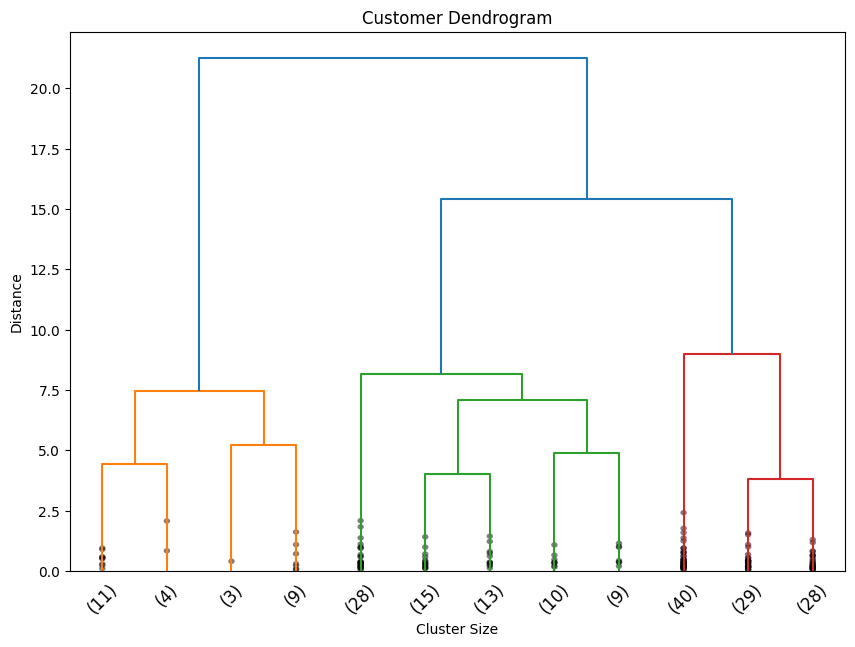

In [36]:
Z = linkage(rfm_scaled, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=12., show_contracted=True)
plt.title('Customer Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

In [37]:
num_clusters = 4
rfm['Cluster_h'] = fcluster(Z, num_clusters, criterion='maxclust')

In [39]:
db_index = davies_bouldin_score(rfm_scaled, rfm['Cluster_h'])
print(f'Davies-Bouldin Index: {db_index}')

silhouette_avg = silhouette_score(rfm_scaled, rfm['Cluster_h'])
print(f'Silhouette Score: {silhouette_avg}')

Davies-Bouldin Index: 0.9860550304034843
Silhouette Score: 0.2675563048182464


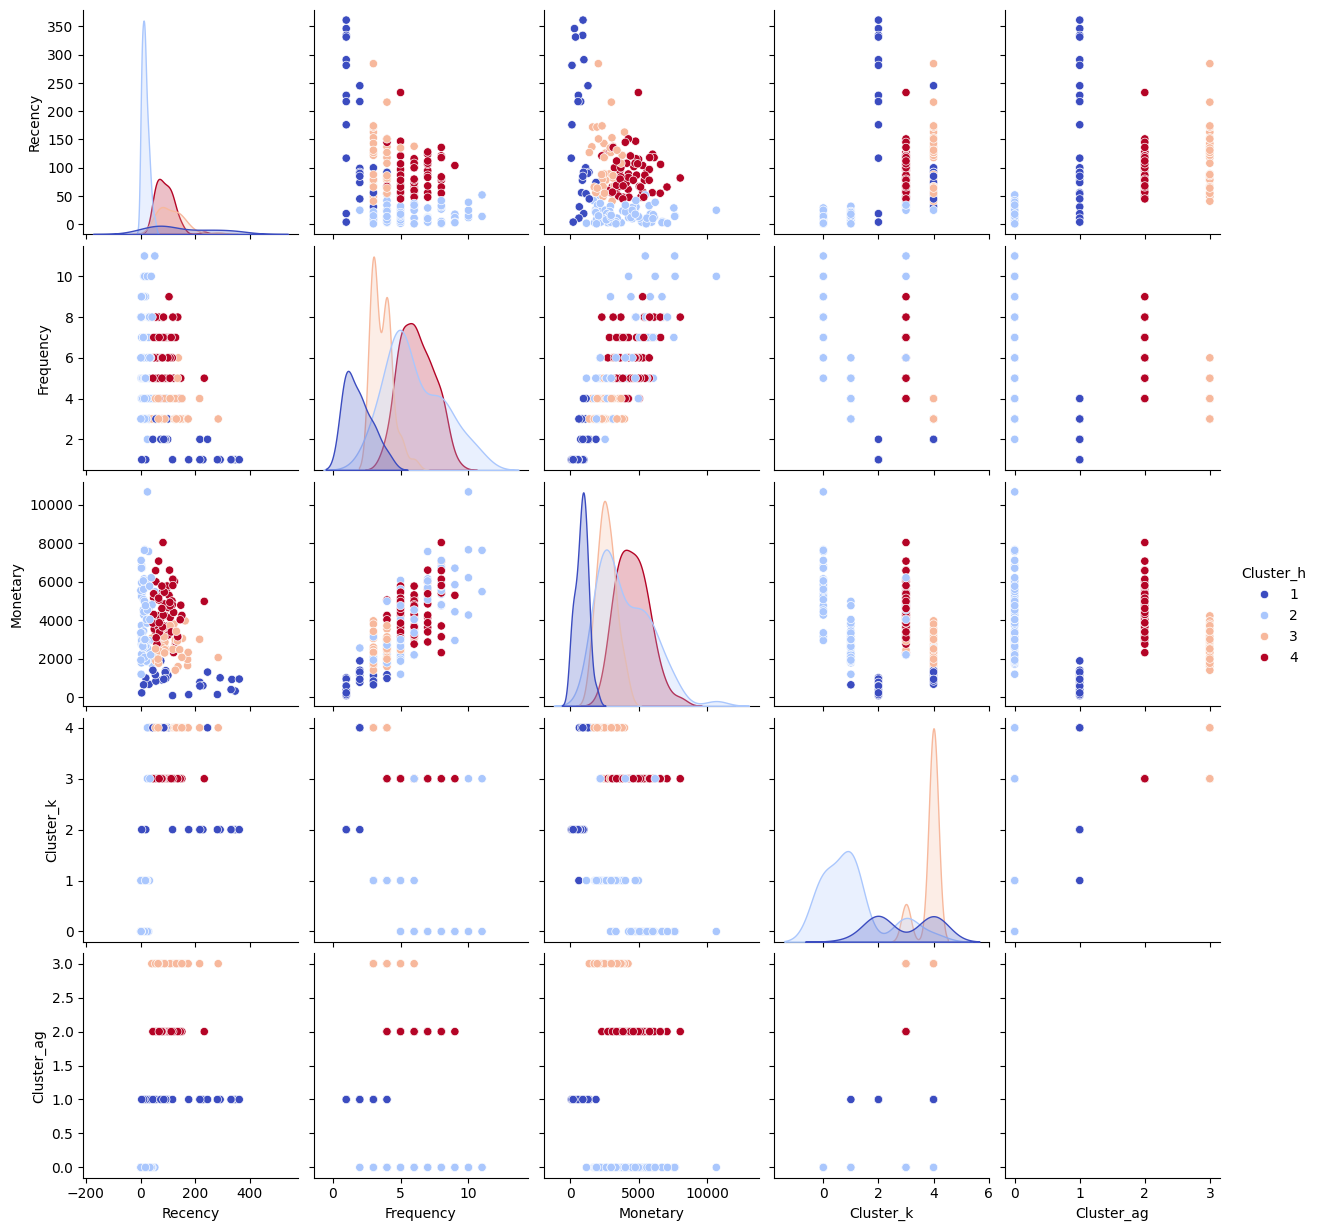

In [40]:
sns.pairplot(rfm, hue='Cluster_h',palette='coolwarm')
plt.show()

   Cluster_h     Recency  Frequency     Monetary  Count
0          1  150.888889   1.888889   843.748148     27
1          2   16.573333   6.013333  4010.712800     75
2          3  111.625000   3.625000  2658.665500     40
3          4   89.842105   6.192982  4562.531228     57


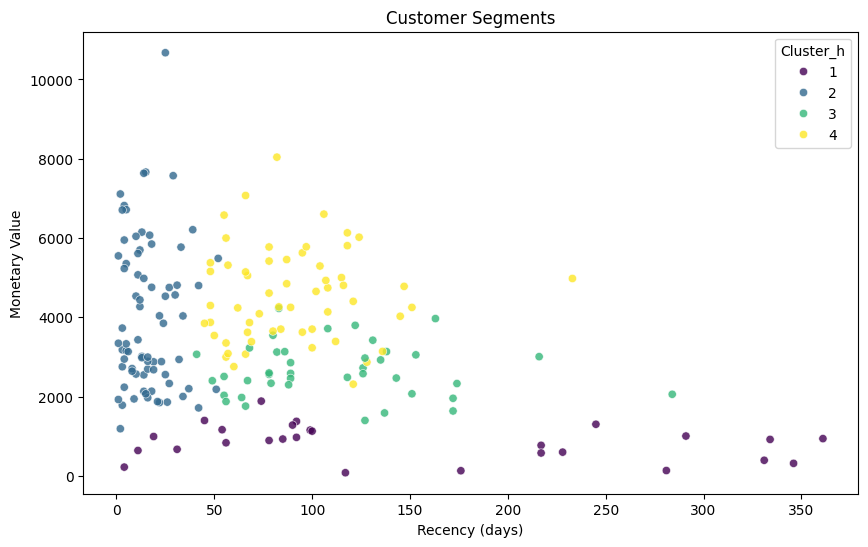

In [41]:
cluster_analysis = rfm.groupby('Cluster_h').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).reset_index()

print(cluster_analysis)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster_h', palette='viridis', alpha=0.8)
plt.title('Customer Segments')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary Value')
plt.show()